# Проект для Интернет-магазина

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import re

from nltk.tokenize import wordpunct_tokenize
from nltk.stem import SnowballStemmer


import sklearn.svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### Чтение таблицы

In [2]:
data = pd.read_csv("../input/toxic-comments/toxic_comments.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### Лемматизация

#### Очистим текст от лишних знаков

In [3]:
def clear_text(text):
    text_re = re.sub(r'[^a-zA-Z]', ' ', text)
    text_split = text_re.lower().split()
    text_finish = " ".join(text_split)
    return text_finish

Сделаем копию таблицы

In [4]:
toxic_data = data.copy()
toxic_data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Применим метод к столбцу с исходным текстом и получим столбец с чистым текстом.

In [5]:
toxic_data['clear_text'] = toxic_data['text'].apply(clear_text)

In [6]:
toxic_data.head(3)

,text,toxic,clear_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...


#### Напишем функцию лемматизации с помощью библиотеки nltk.SnowballStemmer

In [7]:
m = SnowballStemmer('english', ignore_stopwords=True)

def stem(text):
    lemmas = "".join(m.stem(text))
        
    return lemmas

Применим метод к каждой строке в столбце с очищенным текстом.

In [8]:
toxic_data['lemm_text'] = toxic_data['clear_text'].apply(stem)

In [9]:
toxic_data.head(3)

,text,toxic,clear_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man i m really not trying to edit war it s...


### Разделим данные в таблице на тренировочную и тестовую выборки

In [10]:
corpus = toxic_data['lemm_text'].values.astype('U')

Обозначим цели и признаки

In [11]:
target = toxic_data['toxic']
features = corpus

Тестовую выборку сделаем 30% от общего колличества данных.

In [12]:
features

array(['explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now',
       'd aww he matches this background colour i m seemingly stuck with thanks talk january utc',
       'hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info',
       ...,
       'spitzer umm theres no actual article for prostitution ring crunch captain',
       'and it looks like it was actually you who put on the speedy to have the first version deleted now that i look at it',
       'and i really don t think you understand i came here and my idea was bad right away what kind of community goes you have bad ideas go away instead of helping rewrite them'],

In [13]:
features_train_0, features_test_0, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345) 

### Векторизация слов

Вычислим TF-IDF для корпуса текстов.

In [14]:
stopwords = set('../input/nltk-data/nltk_data/corpora/stopwords/english')


count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit_transform(features_train_0)

In [15]:
print("Размер матрицы:", tf_idf.shape)

Размер матрицы: (111699, 140070)


Тестовые признаки трансформируем, но тренировать не будем

In [16]:
tf_idf_test = count_tf_idf.transform(features_test_0)
print("Размер тестовой матрицы:", tf_idf_test.shape)

Размер тестовой матрицы: (47872, 140070)


обозначим признаки:

In [17]:
features_train = tf_idf
features_test = tf_idf_test

In [18]:
features_train

<111699x140070 sparse matrix of type '<class 'numpy.float64'>'
	with 4784146 stored elements in Compressed Sparse Row format>

### Вывод

Мы импортировали необходимые библиотеки в начало проекта, что бы не возникало ошибок, прочитали таблицу, изучили её, очитсили от символов и лемматизировали текст. Потом мы векторизировали текст, превратив его в матрицу признаков для дальнейшего обучения моделей, разбили полученные данные на обучающую и тестовую выборки.

## Обучение

### Модель логистической регрессии

In [19]:
model_log = LogisticRegression(random_state=12345, class_weight='balanced')

In [20]:
model_log.fit(features_train, target_train)

LogisticRegression(class_weight='balanced', random_state=12345)

In [21]:
predictions_log = model_log.predict(features_test)
f1_log = f1_score(target_test, predictions_log)
print('F1 модели логистической регрессии:', '{:.2f}'.format(f1_log))

F1 модели логистической регрессии: 0.75


### Модель случайного леса

Для начала выявим самые подходящие параметры модели с помощью библиотеки optuna.

In [22]:
def objective(trial):
    rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 20))
    rf_n_estimators = int(trial.suggest_loguniform('rf_n_estimators', 2, 70))
    classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_n_estimators, random_state=12345)
        
    score = cross_val_score(classifier_obj, features_train, target_train, scoring='f1', n_jobs=-1, cv=5)
    f1 = score.mean()
    return f1

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)
    print(study.best_trial)

[I 2021-09-21 20:52:55,926] A new study created in memory with name: no-name-55b67ade-cf75-489e-af26-9f376da34efb
[I 2021-09-21 20:53:20,803] Trial 0 finished with value: 0.0010566481912988375 and parameters: {'rf_max_depth': 16.28520726741943, 'rf_n_estimators': 22.94284444341953}. Best is trial 0 with value: 0.0010566481912988375.
[I 2021-09-21 20:53:51,818] Trial 1 finished with value: 0.0 and parameters: {'rf_max_depth': 14.521136624547376, 'rf_n_estimators': 36.98042182218922}. Best is trial 0 with value: 0.0010566481912988375.
[I 2021-09-21 20:54:28,839] Trial 2 finished with value: 0.0 and parameters: {'rf_max_depth': 14.869674317591386, 'rf_n_estimators': 43.688146233442836}. Best is trial 0 with value: 0.0010566481912988375.
[I 2021-09-21 20:54:41,107] Trial 3 finished with value: 0.0 and parameters: {'rf_max_depth': 8.800875873770483, 'rf_n_estimators': 24.917423619595084}. Best is trial 0 with value: 0.0010566481912988375.
[I 2021-09-21 20:54:55,449] Trial 4 finished with va

FrozenTrial(number=0, values=[0.0010566481912988375], datetime_start=datetime.datetime(2021, 9, 21, 20, 52, 55, 932150), datetime_complete=datetime.datetime(2021, 9, 21, 20, 53, 20, 802563), params={'rf_max_depth': 16.28520726741943, 'rf_n_estimators': 22.94284444341953}, distributions={'rf_max_depth': LogUniformDistribution(high=20.0, low=2.0), 'rf_n_estimators': LogUniformDistribution(high=70.0, low=2.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


Обучим модель.

In [23]:
model_forest = RandomForestClassifier(max_depth=27, n_estimators=2, random_state=12345)
model_forest.fit(features_train, target_train)
predictions_forest = model_forest.predict(features_test)
f1_forest = f1_score(target_test, predictions_forest)
print('F1 модели случайного леса:', '{:.2f}'.format(f1_forest))

F1 модели случайного леса: 0.22


### Модель LightGBM

In [24]:
model_gbm = LGBMClassifier(random_state=12345, class_weight='balanced')
model_gbm.fit(features_train, target_train, verbose=10)

LGBMClassifier(class_weight='balanced', random_state=12345)

In [25]:
predictions_gbm = model_gbm.predict(features_test)
f1_gbm = f1_score(target_test, predictions_gbm)

print('F1 модели градиентного бустинга библиотеки lightGBM:', '{:.2f}'.format(f1_gbm))

F1 модели градиентного бустинга библиотеки lightGBM: 0.70


### Модель CatBoost

In [26]:
model_cat = CatBoostClassifier(iterations=100, random_seed=12345)
model_cat.fit(features_train, target_train, verbose=10)

Learning rate set to 0.5
0:	learn: 0.3446791	total: 1.88s	remaining: 3m 6s
10:	learn: 0.1766995	total: 15s	remaining: 2m 1s
20:	learn: 0.1553976	total: 28.2s	remaining: 1m 45s
30:	learn: 0.1436973	total: 40.8s	remaining: 1m 30s
40:	learn: 0.1351158	total: 53.6s	remaining: 1m 17s
50:	learn: 0.1284771	total: 1m 6s	remaining: 1m 3s
60:	learn: 0.1226592	total: 1m 19s	remaining: 50.6s
70:	learn: 0.1188391	total: 1m 32s	remaining: 37.7s
80:	learn: 0.1148276	total: 1m 45s	remaining: 24.7s
90:	learn: 0.1123834	total: 1m 58s	remaining: 11.7s
99:	learn: 0.1094943	total: 2m 10s	remaining: 0us


In [27]:
predictions_cat = model_cat.predict(features_test)
f1_cat = f1_score(target_test, predictions_cat)

print('F1 модели градиентного бустинга библиотеки CatBoost:', '{:.2f}'.format(f1_cat))

F1 модели градиентного бустинга библиотеки CatBoost: 0.75


### Вывод

Мы обучили несколько моделей на полученных нами признаках. Лучше всех с задачей справилась модель логистической регрессии и CatBoost.

## Выводы

Подведём итоги и выясним, какая же модель справилась с поставленной нами задачей лучше всех.

Для наглядности напечатаем таблицу и выведем график сравнения метрик всех наших моделей.

,F1
Линейная регрессия,0.748762
Случайный лес,0.224708
LGBM,0.696794
CatBoost,0.754987


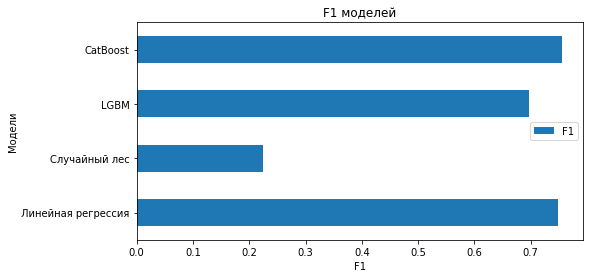

In [28]:
final_table = pd.DataFrame(index=[
    'Линейная регрессия', 
    'Случайный лес', 
    'LGBM', 
    'CatBoost'
], columns=['F1'], data=[
    f1_log, 
    f1_forest, 
    f1_gbm, 
    f1_cat]
                          )

display(final_table)
final_table.plot.barh(figsize=(8, 4))
plt.ylabel('Модели')
plt.xlabel('F1')
plt.title('F1 моделей')
plt.show()

**Лучшей из всех моделей оказалась модель логистической регрессии**. 

Модель логистической регрессии дала нам самую высокую метрику качества F1 и единственная, кто смог преодолеть заявленный порог в 0.75. 

Модель градиентного бустинга LightGBM была близка к модели регрессии, но всё же оказалась не такиой точной, хотя и обучалась намного дольше по времени. 

Модель градиентного бустинга CatBoost сравнилась с моделью регрессии, но обучались намного дольше по времени.

Самой худшей моделью для распознавания тональности текста оказалась модель случайного леса.

## Вывод

В данном проекте нам была поставлена задача обучить модель классифицировать комментарии на позитивные и негативные. Условием к успешному выполнению проекта была метрика обученной модели F1 не ниже 0.75. 

Чтобы добиться успеха мы очистили от лишних символов, лемматизировали текст и убрали из него стоп-слова в каждой строке таблицы. После чего придали полученные данные процедуре векторизации текста. Вычислив TF-IDF для корпуса текстов, на выходе мы получили матрицу признаков.

Далее нашу матрицу признаков и столбец с целевым признаком мы поделили на тренировочную и тестовую выборки, после чего на тренировочной выборке обучили модели логистической регрессии, случайного леса, а также модели градиентного бустинга LightGBM и CatBoost.

Быстрее всех с обучением справилась модель логистической регрессии, т.к. ей не приходилось подбирать параметры.

В итоге, когда мы построили таблицу сравнения метрик различных моделей, а также вывели график, мы увидели, что самой точной моделью оказалась модель логистической регрессии и модель градиентного бустинга CatBoost.

Для классификации комментариев на позитивные и негативные использовать будем обученную нами **модель логистической регрессии** или **CatBoost**.